# Compare Gaussian fits across all flights

In [61]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import pickle, glob, yaml

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
from beamcals.sites import site
from astropy.modeling.models import AiryDisk2D

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')


freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

In [62]:
def get_flightinfo(fly):
    with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
        documents = yaml.safe_load(fff)
    flights = documents["flight_info"]["flights"]
    
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_slice(beam,Z,val,ax='x'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[0,1,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[0,:,0])
    ok = True
    while(ok):
        if ax=='x':
            col = np.where((beam.x_centers_grid[0,:,0] < val+tol) & (beam.x_centers_grid[0,:,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        if ax=='y':
            col = np.where((beam.y_centers_grid[:,0,0] < val+tol) & (beam.y_centers_grid[:,0,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=3
        if tol > 30: ok = False
    return col

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col

def get_slice_xy(xes,yes,val,ax='x'):
    tol = 2
    if ax=='x':
        col = np.where((xes < val+tol) & (xes > val-tol))[0]
    if ax=='y':
        col = np.where((yes < val+tol) & (yes > val-tol))[0]
    return col

def Gauss_2D_fromgrid(beam,concat,find,chind):
    xes = np.ndarray.flatten(beam.x_centers_grid[:,:,0])
    yes = np.ndarray.flatten(beam.y_centers_grid[:,:,0])
    Gfit = np.zeros(beam.V_LC_operation[:,:,0,0].shape)
    P = [1.0,0.0,concat.G_popt[chind,find,2],0.0,
        concat.G_popt[chind,find,4],concat.G_popt[chind,find,5]]
    #fits = fu.Gauss_2d_LC_func(concat.G_popt[chind,find,:-1],xes,yes)
    fits = fu.Gauss_2d_LC_func(P,xes,yes)
    reshapefits = fits.reshape((beam.x_centers_grid[:,:,0].shape))
    return reshapefits

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    return stat

In [63]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] []


In [64]:
fly1 = '648'

# Get info
pol, pols, cpols, attn, fi = get_flightinfo(fly1)
print(fly1,pol,pols,cpols, attn)
print(pcklarr[fi])

# Choose which dish here
chind = pols[0]
print(chind)


648 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15] 40
FLY648_20211022T191922Z_ver_20231012T031117_concat.pkl
0


# Fitting checks

/hirax/GBO_Analysis_Outputs/main_beam_fits/FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz


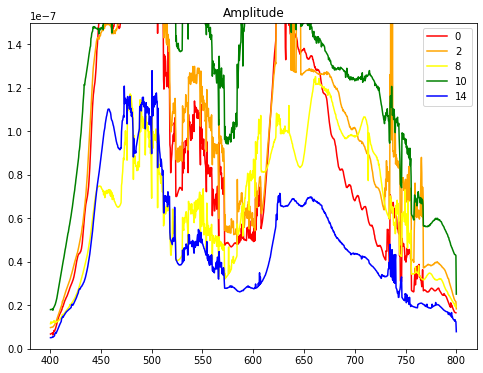

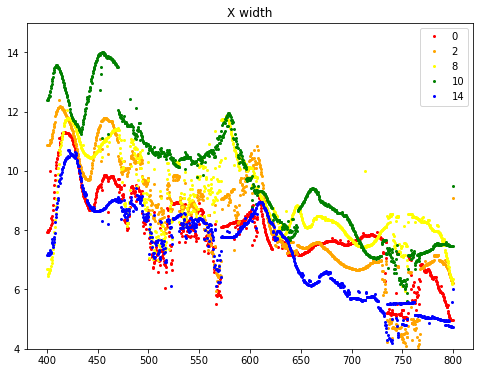

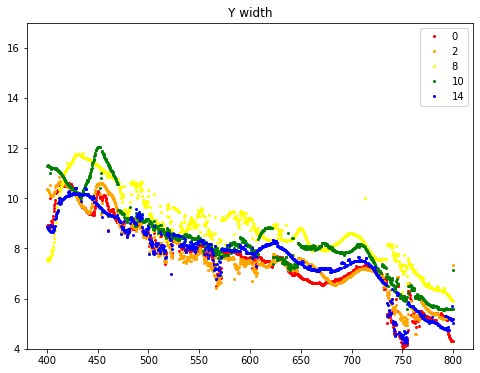

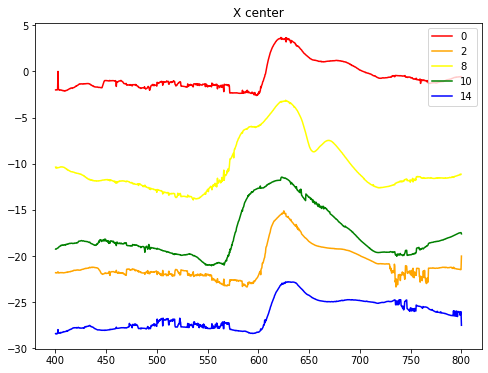

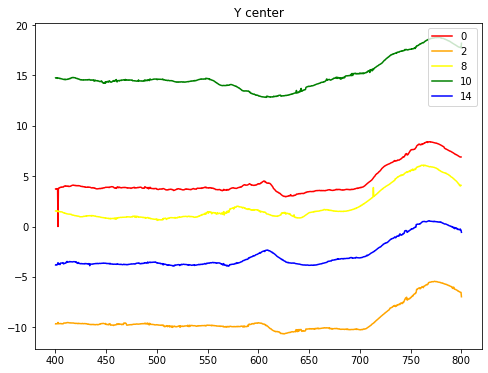

In [65]:
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','yellow','green','blue','purple','pink']

# amp
fig = plt.figure(figsize=(8,6))
ffile = glob.glob(fitdir+gfitarr[fi])[0]
print(ffile)
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,0],markersize=4,color=colors[pp],label=str(p))
plt.title('Amplitude')
plt.legend()
plt.ylim(0,1.5E-7)
plt.show()

# X width
fig = plt.figure(figsize=(8,6))
ffile = glob.glob(fitdir+gfitarr[fi])[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,2],markersize=4,marker='.',color=colors[pp],linestyle='None',label=str(p))
plt.title('X width')
plt.legend()
plt.ylim(4,15)
plt.show()

# Y width
fig = plt.figure(figsize=(8,6))
ffile = glob.glob(fitdir+gfitarr[fi])[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,4],markersize=4,marker='.',linestyle='None',color=colors[pp],label=str(p))
plt.title('Y width')
plt.legend()
plt.ylim(4,17)
plt.show()

# X center
fig = plt.figure(figsize=(8,6))
ffile = glob.glob(fitdir+gfitarr[fi])[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,1],markersize=4,color=colors[pp],label=str(p))
plt.title('X center')
plt.legend()
#plt.ylim(4,14)
plt.show()

# Y center
fig = plt.figure(figsize=(8,6))
ffile = glob.glob(fitdir+gfitarr[fi])[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,3],markersize=4,color=colors[pp],label=str(p))
plt.title('Y center')
plt.legend()
#plt.ylim(4,14)
plt.show()


/hirax/GBO_Analysis_Outputs/main_beam_fits/FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz
/hirax/GBO_Analysis_Outputs/2023_SpringSummer_products/main_beam_fits/FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz


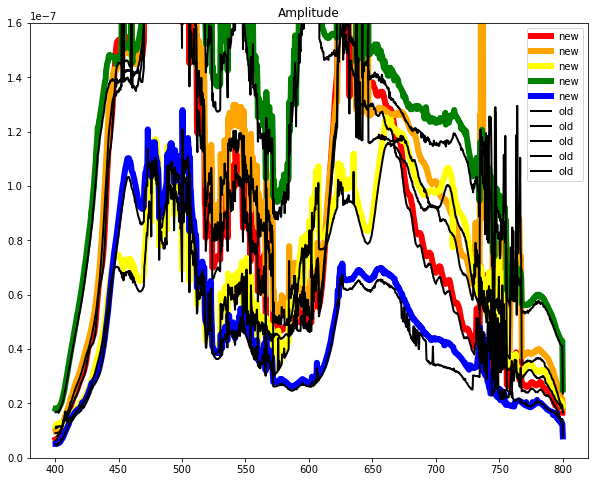

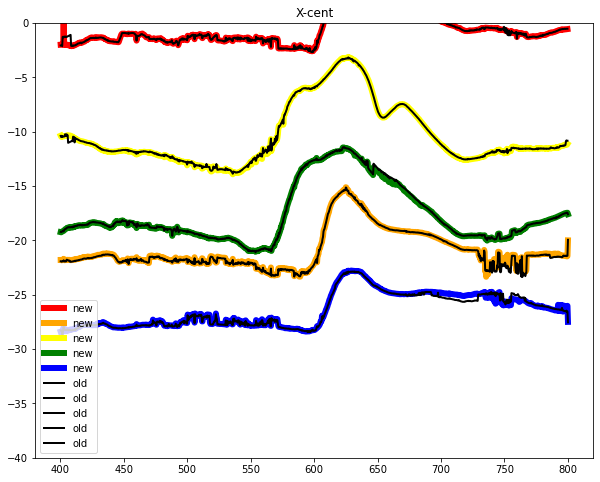

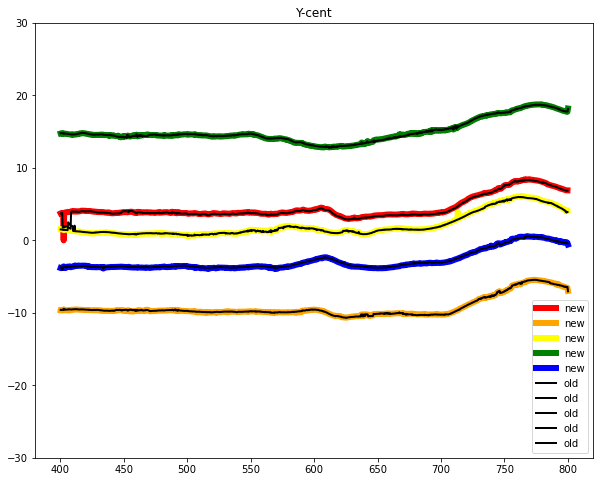

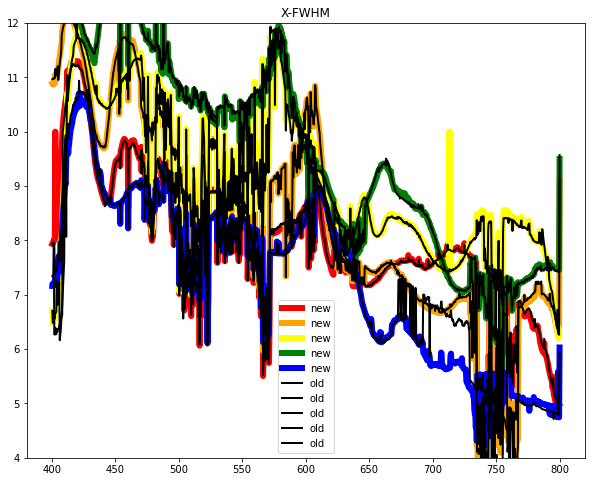

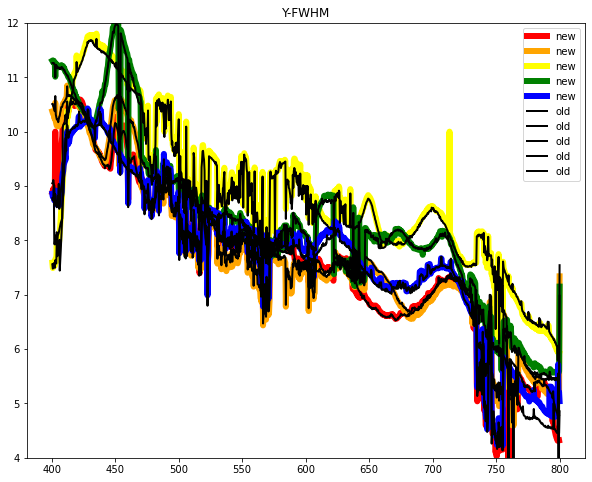

In [66]:
# compare old to new
oldfitdir = '/hirax/GBO_Analysis_Outputs/2023_SpringSummer_products/main_beam_fits/'

# amp
fig = plt.figure(figsize=(10,8))
ffile = glob.glob(fitdir+'FLY*'+fly1+'*')[0]
print(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,0],linewidth=6,color=colors[pp],label='new')
plt.title('Amplitude')
plt.legend()
plt.ylim(0,1.6E-7)

ffile = glob.glob(oldfitdir+'FLY*'+fly1+'*')[0]
fits = np.load(ffile)
print(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,0],linewidth=2,color='black',label='old')
plt.title('Amplitude')
plt.legend()
plt.ylim(0,1.6E-7)

plt.show()

# cent - X
fig = plt.figure(figsize=(10,8))
ffile = glob.glob(fitdir+gfitarr[fi])[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,1],linewidth=6,color=colors[pp],label='new')

ffile = glob.glob(oldfitdir+'FLY*'+fly1+'*')[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,1],linewidth=2,color='black',label='old')
plt.title('X-cent')
plt.legend()
plt.ylim(-40,0)

plt.show()

# cent - Y
fig = plt.figure(figsize=(10,8))
ffile = glob.glob(fitdir+gfitarr[fi])[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,3],linewidth=6,color=colors[pp],label='new')

ffile = glob.glob(oldfitdir+'FLY*'+fly1+'*')[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,3],linewidth=2,color='black',label='old')
plt.title('Y-cent')
plt.legend()
plt.ylim(-30,30)
plt.legend()
plt.show()

# FWHM - X
fig = plt.figure(figsize=(10,8))
ffile = glob.glob(fitdir+gfitarr[fi])[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,2],linewidth=6,color=colors[pp],label='new')

ffile = glob.glob(oldfitdir+'FLY*'+fly1+'*')[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,2],linewidth=2,color='black',label='old')
plt.title('X-FWHM')
plt.legend()
plt.ylim(4,12)

plt.show()

# FWHM - Y
fig = plt.figure(figsize=(10,8))
ffile = glob.glob(fitdir+gfitarr[fi])[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,4],linewidth=6,color=colors[pp],label='new')


ffile = glob.glob(oldfitdir+'FLY*'+fly1+'*')[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,4],linewidth=2,color='black',label='old')
plt.title('Y-FWHM')
plt.legend()
plt.ylim(4,12)

plt.show()


In [ ]:
# compare old to new
oldfitdir = '/hirax/GBO_Analysis_Outputs/2023_SpringSummer_products/main_beam_fits/'


# amp
fig = plt.figure(figsize=(10,8))
ffile = glob.glob(fitdir+gfitarr[fi])[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,0],marker='x',linestyle='None',color=colors[pp],label='new')
plt.title('Amplitude')
plt.legend()
plt.ylim(0,1.6E-7)

ffile = glob.glob(oldfitdir+'FLY623*')[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,0],marker='x',linestyle='None',color='black',label='old')
plt.title('Amplitude')
plt.legend()
plt.ylim(0,1.6E-7)

plt.show()

# cent - X
fig = plt.figure(figsize=(10,8))
ffile = glob.glob(fitdir+gfitarr[fi])[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,1],marker='x',linestyle='None',color=colors[pp],label='new '+str(p))

ffile = glob.glob(oldfitdir+'FLY623*')[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,1],marker='x',linestyle='None',color='black',label='old '+str(p))
plt.title('X-cent')
plt.legend()
plt.ylim(-40,0)

plt.show()

# cent - Y
fig = plt.figure(figsize=(10,8))
ffile = glob.glob(fitdir+gfitarr[fi])[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,3],marker='x',linestyle='None',color=colors[pp],label='new '+str(p))

ffile = glob.glob(oldfitdir+'FLY623*')[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,3],marker='x',linestyle='None',color='black',label='old '+str(p))
plt.title('Y-cent')
plt.legend()
plt.ylim(-30,30)
plt.legend()
plt.show()

# FWHM - X
fig = plt.figure(figsize=(10,8))
ffile = glob.glob(fitdir+gfitarr[fi])[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,2],marker='x',linestyle='None',color=colors[pp],label='new '+str(p))

ffile = glob.glob(oldfitdir+'FLY623*')[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,2],marker='x',linestyle='None',color='black',label='old '+str(p))
plt.title('X-FWHM')
plt.legend()
plt.ylim(4,12)

plt.show()

# FWHM - Y
fig = plt.figure(figsize=(10,8))
ffile = glob.glob(fitdir+gfitarr[fi])[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,4],marker='x',linestyle='None',color=colors[pp],label='new '+str(p))


ffile = glob.glob(oldfitdir+'FLY623*')[0]
fits = np.load(ffile)
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,4],marker='x',linestyle='None',color='black',label='old '+str(p))
plt.title('Y-FWHM')
plt.legend()
plt.ylim(4,12)

plt.show()

In [ ]:
radfile = pckldir+pcklarr[fi]

#oldpckldir = '/hirax/GBO_Analysis_Outputs/2023_SpringSummer_products/flight_pickles/'
#oldpcklarr = np.sort(os.listdir(oldpckldir))
#radfile = oldpckldir+oldpcklarr[fi]

print('Loading: ',radfile)
with open(radfile, 'rb') as inp:
    ptest = pickle.load(inp)
    
t_cut=ptest.inds_on


In [ ]:
find = 900#938#538#900
chind = pols[0]

x = ptest.drone_xyz_per_dish_interp[chind,t_cut,0]
y = ptest.drone_xyz_per_dish_interp[chind,t_cut,1]
z = ptest.V_bgsub[t_cut,find,chind]

# plot scatter plot and beam map
plt.scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm())
plt.show()



In [ ]:
slc = get_slice_xy(x,y,0.0,'y')


plt.figure(1,figsize=(10,10))
plt.scatter(x[slc],y[slc],c=z[slc])#,cmap=cm.jet,norm=LogNorm())
#plt.ylim(-15,15)
#plt.xlim(5.35,5.48)
plt.colorbar()
plt.show()




In [ ]:
plt.figure(1,figsize=(10,10))
for find in good_freqs[0:10]:

    x = ptest.drone_xyz_per_dish_interp[chind,t_cut,0]
    y = ptest.drone_xyz_per_dish_interp[chind,t_cut,1]
    z = ptest.V_bgsub[t_cut,find,chind]


    plt.plot(x[slc],z[slc],marker='.',linestyle='None',label=str(find))
    #plt.ylim(-15,15)
    #plt.xlim(5.35,5.48)
plt.show()

In [ ]:
t_span = ptest.inds_span
t_off = ptest.inds_off
#plt.plot(ptest.V_bgsub[t_cut,find,chind])
#plt.plot(ptest.V_bgsub[t_span,find,chind])
plt.plot(ptest.V_bgsub[t_off,find,chind])
plt.show()
print(ptest.V_bgsub[t_off,find,chind])